# 粒子フィルタ学習 / Learning particle filter
参考書：「基礎からわかる時系列分析」（萩原淳一郎、技術評論社）

## 1. 準備 / Settings

In [1]:
from math import *

import numpy as np
from numpy.random import *
from scipy.stats import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

## 2. 一般状態空間モデルにおける推定例

### 2.0 関数

#### 対数領域のベクトルの規格化

In [2]:
def normalize(l):
    output = l - max(l) - np.log1p(sum(np.exp(l - max(l)))-1)
    return output

#### 系統リサンプリング

In [3]:
def resampling(w):
    
    n_particle = len(w)    # 粒子数
    w_cumsum = np.cumsum(np.exp(w))    # 重みの経験分布
    
    k = np.ndarray(shape=(n_particle))
    
    idx = 0
    for i in range(n_particle):
        quantile = (i + 1/2 + 0.6*rand() - 0.3) / n_particle
        if quantile <= w_cumsum[idx]:
            k[i] = idx
        else:
            while True:
                idx += 1
                if quantile <= w_cumsum[idx]:
                    k[i] = idx
                    break
                else:
                    continue
    
    return k

### 2.1 非線形の著名なベンチマークモデル
$x_t = \frac{1}{2} x_{t-1} + \frac{25 x_{t-1}}{1 + x^2_{t-1}} + 8 \cos{1.2 t} + w_t, \qquad w_t \sim \mathcal{N}(0,W)$ ...state equation<br>
$y_t = \frac{x^2_t}{20} + v_t, \qquad \qquad \qquad \qquad \qquad v_t \sim \mathcal{N} (0,V)$ ...observation equation<br>
$v_t$: Irregular

#### 2.1.1 データの生成 / generate data

In [4]:
np.random.seed(23)

# パラメータの設定
W = 1
V = 2
m0 = 10
C0 = 9

# 状態方程式
def state_eq(x,t):
    output = 1/2 * x + 25 * x / (1 + x**2) + 8 * cos(1.2 * t)
    return output

# 観測方程式
def obs_eq(x):
    output = x**2 /20
    return output

# 時系列長
t_max = 100

x_true = np.ndarray(shape=(t_max+1))
y = np.ndarray(shape=(t_max))

# 事前分布
x_true[0] = m0

# データの生成
for t in range(t_max):
    x_true[t+1] = state_eq(x_true[t],t) + normal(0,W)
    
    y[t] = obs_eq(x_true[t]) + normal(0,V)

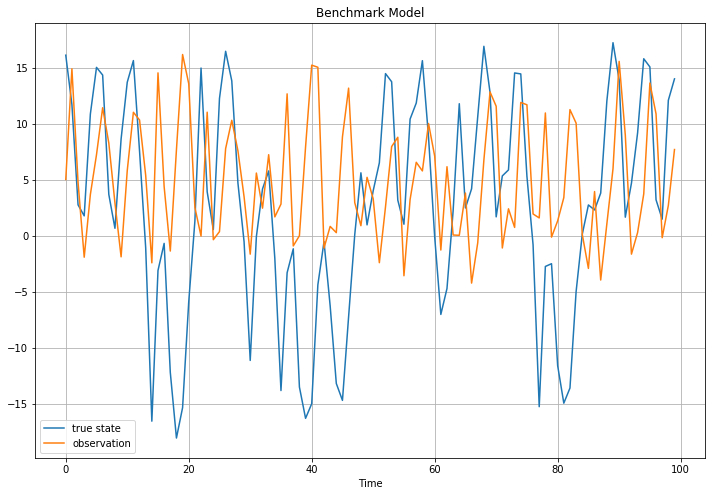

In [5]:
plt.figure(figsize=(12,8))
pl_true = plt.plot([i for i in range(t_max)], x_true[1:])
pl_obs  = plt.plot([i for i in range(t_max)], y)
plt.grid(True)
plt.title('Benchmark Model')
plt.xlabel('Time')
plt.legend((pl_true[0],pl_obs[0]),("true state","observation"), loc='best')
plt.show()

#### 2.1.2 粒子フィルタの適用 / Apply particle filter

In [6]:
np.random.seed(23)

N = 10000    # 粒子数

# 粒子の実現値
x = np.ndarray(shape=(t_max+1, N))
x[0,] = normal(m0,sqrt(C0),size=(N))

# 粒子の重み
w = np.ndarray(shape=(N))

k = np.ndarray(shape=(N),dtype=np.int16)

for t in range(t_max):
    
    # 状態方程式から粒子の実現値を生成
    x[t+1,] = normal(state_eq(x[t,],t),sqrt(W),size=(N))
    
    # 粒子の重みを更新 + 規格化
    w = log(1/N) + norm.logpdf(y[t],obs_eq(x[t+1]),sqrt(V))
    w = normalize(w)
    
    # リサンプリングのインデックス列
    k = resampling(w)

    # リサンプリング
    x[t+1,] = x[t+1,np.int16(k)]

x_calc = np.mean(x[1:],axis=1)

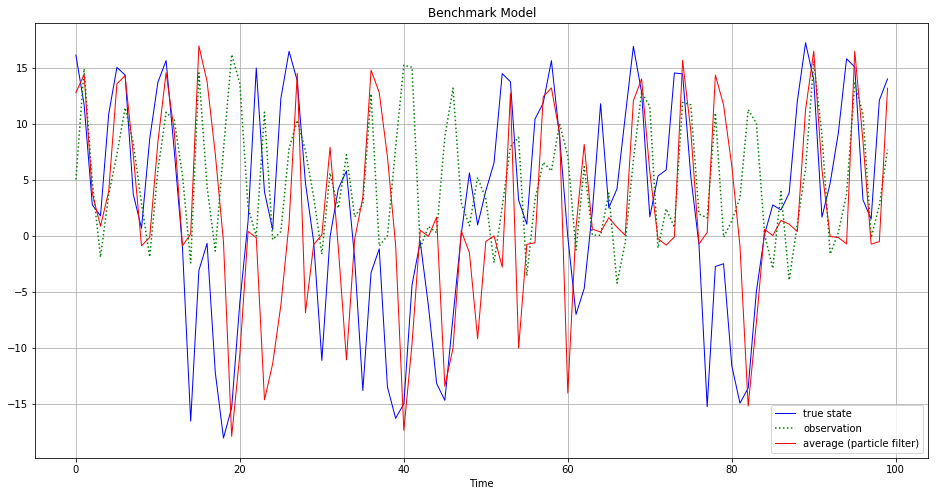

In [7]:
plt.figure(figsize=(16,8))
pl_true = plt.plot([i for i in range(t_max)], x_true[1:],color='blue',linewidth=1)
pl_obs  = plt.plot([i for i in range(t_max)], y, color='green', linestyle='dotted')
pl_calc = plt.plot([i for i in range(t_max)], x_calc, color='red', linewidth=1)
plt.grid(True)
plt.title('Benchmark Model')
plt.xlabel('Time')
plt.legend((pl_true[0],pl_obs[0],pl_calc[0]),("true state","observation",'average (particle filter)'), loc='best')
plt.show()

## 3. 精度向上のためのテクニック

## 3.1 補助粒子フィルタ

#### データの読み込み

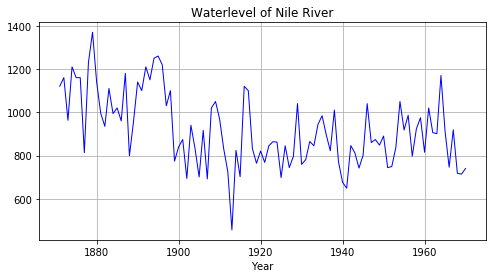

In [8]:
nile = np.loadtxt('nile.csv',delimiter=',',skiprows=1)
year = nile[:,0]
waterlevel = nile[:,1]

plt.figure(figsize=(8,4))
pl_wl = plt.plot(year, waterlevel,color='blue',linewidth=1)
plt.grid(True)
plt.title('Waterlevel of Nile River')
plt.xlabel('Year')
plt.show()

#### ローカルレベルモデルを仮定 + パラメータの最尤推定

<a href="https://www.statsmodels.org/dev/statespace.html">statsmodels.tsa.statespace のreference</a> <br>
<a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents">statsmodels.tsa.statespace.structural.UnobservedComponents のreferrence</a> <br>
<a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor.DynamicFactor.html#statsmodels.tsa.statespace.dynamic_factor.DynamicFactor">statsmodels.tsa.statespace.dynamic_factor.DynamicFactor のreference</a><br>

In [9]:
np.random.seed(4521)

model = sm.tsa.UnobservedComponents(waterlevel, 'local level')
model = model.fit()

print(model.summary())

V = model.params[0]
W = model.params[1]

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -632.538
Date:                Sun, 07 Apr 2019   AIC                           1269.076
Time:                        16:58:42   BIC                           1274.266
Sample:                             0   HQIC                          1271.176
                                - 100                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.508e+04   2586.506      5.829      0.000       1e+04    2.01e+04
sigma2.level      1478.8116    851.329      1.737      0.082    -189.762    3147.385
Ljung-Box (Q):              

In [10]:
t_max = len(waterlevel)    # 時系列長
N = 10000                  # 粒子数

m0 = 0
C0 = 10**7

# 粒子の実現値
x = np.ndarray(shape=(t_max+1, N))
x[0,] = normal(m0,sqrt(C0),size=(N))

# 粒子の重み
w = np.ndarray(shape=(N))
w = log(1/N)
k = np.ndarray(shape=(N),dtype=np.int16)

for t in range(t_max):
    
    # 補助変数列
    probs = w + norm.logpdf(waterlevel[t],x[t,],sqrt(V))
    k = resampling(normalize(probs))
    
    # 状態方程式から粒子の実現値を生成
    x[t+1,] = normal(x[t,np.int16(k)],sqrt(W),size=(N))
    
    # 粒子の重みを更新 + 規格化
    w = norm.logpdf(waterlevel[t],x[t+1,],sqrt(V)) - norm.logpdf(waterlevel[t],x[t,np.int16(k)],sqrt(V))
    w = normalize(w)
    
    # リサンプリングのインデックス列
    k = resampling(w)

    # リサンプリング
    x[t+1,] = x[t+1,np.int16(k)]

x_calc = np.mean(x[1:],axis=1)

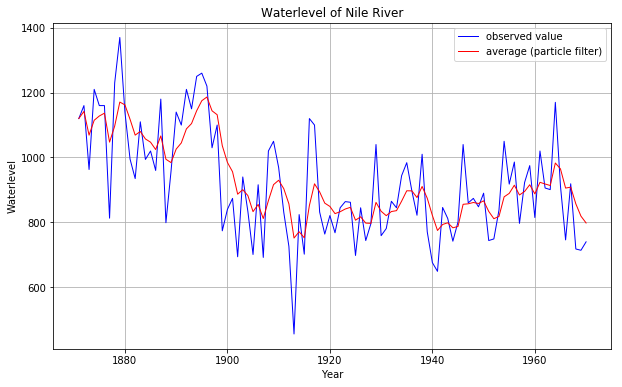

In [12]:
plt.figure(figsize=(10,6))
pl_wl = plt.plot(year, waterlevel,color='blue',linewidth=1)
pl_calc = plt.plot(year, x_calc, color='red',linewidth=1)
plt.grid(True)
plt.legend((pl_wl[0],pl_calc[0]),("observed value",'average (particle filter)'), loc='best')
plt.title('Waterlevel of Nile River')
plt.xlabel('Year')
plt.ylabel('Waterlevel')
plt.show()